## Descrição do Desenvolvimento do Case: Modelo preditivo para aprovação de crédit 

O case foi desenvolvido a partir de uma modelagem em duas etapas. Na primeira, através do classificador XGBOOST, foi criado um "score interno" a partir das variáveis internas (ou seja, retirando os scores de Bureau). Na segunda etapa, fez-se uso de um classificador Logístico para "combinar" os scores de Bureau ao score interno (gerado na etapa anterior) a fim de retornar a probabilidade final do cliente ser inadimplente, bem como uma flag de inadimplência. Vale ressaltar que em ambas etapas utilizou-se o método de validação K-fold estratificado repetido, a fim de equalizar a característica de desbalanceamento encontrada na variável resposta. 

Na base de teste foram incluídas três novas variáveis:

1 - score_interno = Score Construído na Primeira etapa da modelagem

2 - probabilidade_inadimplente = a probabilidade de inadimplência de cada novo pedido de crédito

3 - inadimplente = o status da inadimplência de cada novo pedido de crédito

## Importando Libs Necessárias

In [2]:
import cloudpickle as cp
import boto3
from sklearn import preprocessing
import cloudpickle as cp
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator, TransformerMixin
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
import joblib
sns.set(style="whitegrid", color_codes=True)
import pandas as pd                                    # Manipulação de tabelas
import numpy as np                                     # Operações matemáticas
import warnings                                        # Remover warnings
import boto3                                           # Manipular funções dentro da AWS
import gc                                              # Limpa memória do cache
from pandas_profiling import ProfileReport
from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn.model_selection import StratifiedKFold    # Cria KFold estratificado
from sklearn.model_selection import RandomizedSearchCV # Busca Aleatória de Parâmetros
import scipy.stats
warnings.filterwarnings("ignore")             # Ignora warnings
pd.set_option('display.max_columns', None)    # Remove limitador de colunas quando mostra a tabela

## Definindo Parâmetros de Conexão à AWS

In [3]:
NM_BUCKET      = 'turing-bkt-laion'
ID_CLIENTE     = '1019'
CAMINHO = 'Bases/CASES/LENDICO'
ARQUIVO = 'case_train[1].csv'
S3fs, S3session, S3client, S3resource = TuringUsersCredentialsControl(ID_EMPRESA)
NOME_DA_TARGET = 'inadimplente'

## Importação da Base de Dados

In [4]:
base_raw = boto3.client('s3').get_object(Bucket=NM_BUCKET, Key=CAMINHO + ARQUIVO)
base_raw = pd.read_csv(base_raw['Body'], sep=',', encoding='latin-1') # Rodando base Full
print('A Base importada tem', base_raw.shape[0], 'linhas e', base_raw.shape[1], 'colunas.')
base_raw_backup = base_raw.copy()

A Base importada tem 77000 linhas e 15 colunas.


## 1. Breve Descritivo e Exploratório das Variáveis

In [5]:
print('As variáveis presentas na base de dados são:',base_raw.columns.values)

As variáveis presentas na base de dados são: ['inadimplente' 'util_linhas_inseguras' 'idade'
 'vezes_passou_de_30_59_dias' 'razao_debito' 'salario_mensal'
 'numero_linhas_crdto_aberto' 'numero_vezes_passou_90_dias'
 'numero_emprestimos_imobiliarios' 'numero_de_vezes_que_passou_60_89_dias'
 'numero_de_dependentes' 'score_1' 'score_2' 'score_3' 'score_4']


### 1.1 Análise Gráfica e Tratamento de Outliers das Variáveis Preditoras do Score Interno

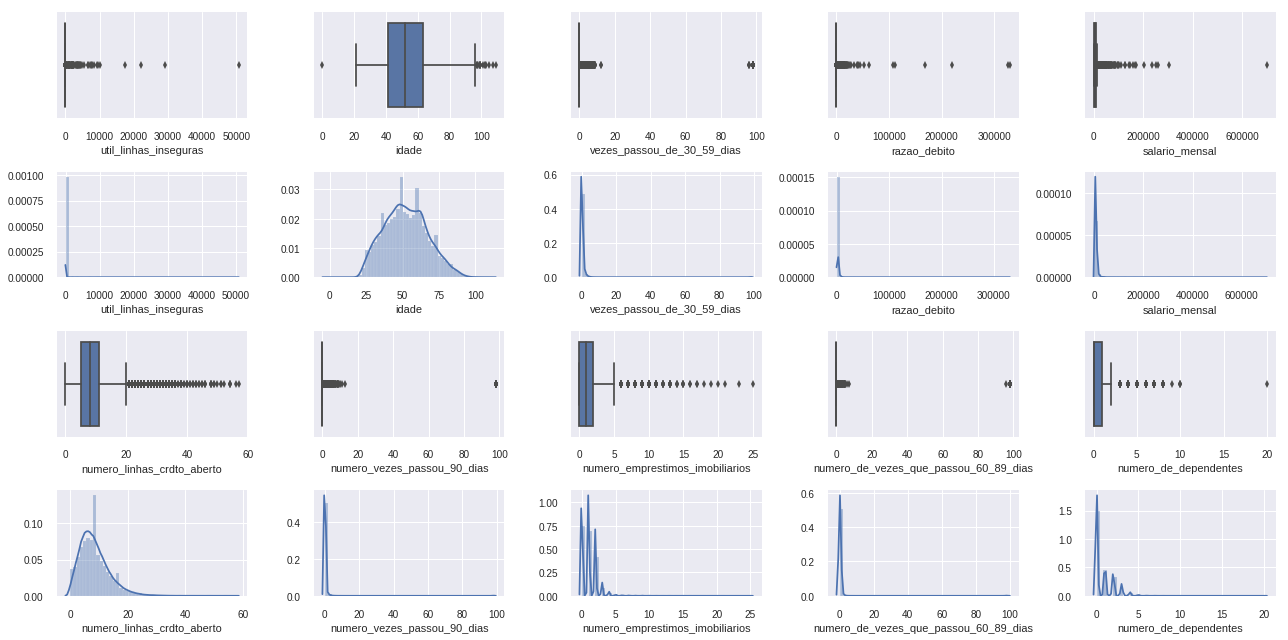

In [6]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(18,9))

sns.boxplot(base_raw['util_linhas_inseguras'], ax=axs[0,0])
sns.boxplot(base_raw['idade'], ax=axs[0,1])
sns.boxplot(base_raw['vezes_passou_de_30_59_dias'], ax=axs[0,2])
sns.boxplot(base_raw['razao_debito'], ax=axs[0,3])
sns.boxplot(base_raw['salario_mensal'], ax=axs[0,4])
sns.boxplot(base_raw['numero_linhas_crdto_aberto'], ax=axs[2,0])
sns.boxplot(base_raw['numero_vezes_passou_90_dias'], ax=axs[2,1])
sns.boxplot(base_raw['numero_emprestimos_imobiliarios'], ax=axs[2,2])
sns.boxplot(base_raw['numero_de_vezes_que_passou_60_89_dias'], ax=axs[2,3])
sns.boxplot(base_raw['numero_de_dependentes'], ax=axs[2,4])


sns.distplot(base_raw['util_linhas_inseguras'], ax=axs[1,0])
sns.distplot(base_raw['idade'], ax=axs[1,1])
sns.distplot(base_raw['vezes_passou_de_30_59_dias'], ax=axs[1,2])
sns.distplot(base_raw['razao_debito'], ax=axs[1,3])
sns.distplot(base_raw['salario_mensal'], ax=axs[1,4])
sns.distplot(base_raw['numero_linhas_crdto_aberto'], ax=axs[3,0])
sns.distplot(base_raw['numero_vezes_passou_90_dias'], ax=axs[3,1])
sns.distplot(base_raw['numero_emprestimos_imobiliarios'], ax=axs[3,2])
sns.distplot(base_raw['numero_de_vezes_que_passou_60_89_dias'], ax=axs[3,3])
sns.distplot(base_raw['numero_de_dependentes'], ax=axs[3,4])


fig.tight_layout()

In [7]:
class TrataOutlier(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.li = {}
        self.ls = {}
        self.num_cols = None
    
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes('number').columns.tolist()
        for col in self.num_cols:
            q1, q3 = X[col].quantile(q=[.25, .75])
            iqr = q3 - q1
            li = q1 - 1.5 * iqr
            ls = q3 + 1.5 * iqr
            
            self.li[col] = li
            self.ls[col] = ls
        return self
    
    def transform(self, X):
        for col in X.select_dtypes('number').columns:
            if col not in self.num_cols:
                print(f'Coluna {col} não existe na tabela')
                pass
            else:
                X.loc[X[col] < self.li[col], col] = self.li[col]
                X.loc[X[col] > self.ls[col], col] = self.ls[col]
        
        return X

In [8]:
trata_outlier = TrataOutlier()
cols_numericas = ['util_linhas_inseguras','idade',
                  'razao_debito','salario_mensal','numero_linhas_crdto_aberto',
                  'numero_emprestimos_imobiliarios','numero_de_dependentes']
base_raw.loc[:, cols_numericas] = trata_outlier.fit_transform(base_raw[cols_numericas])

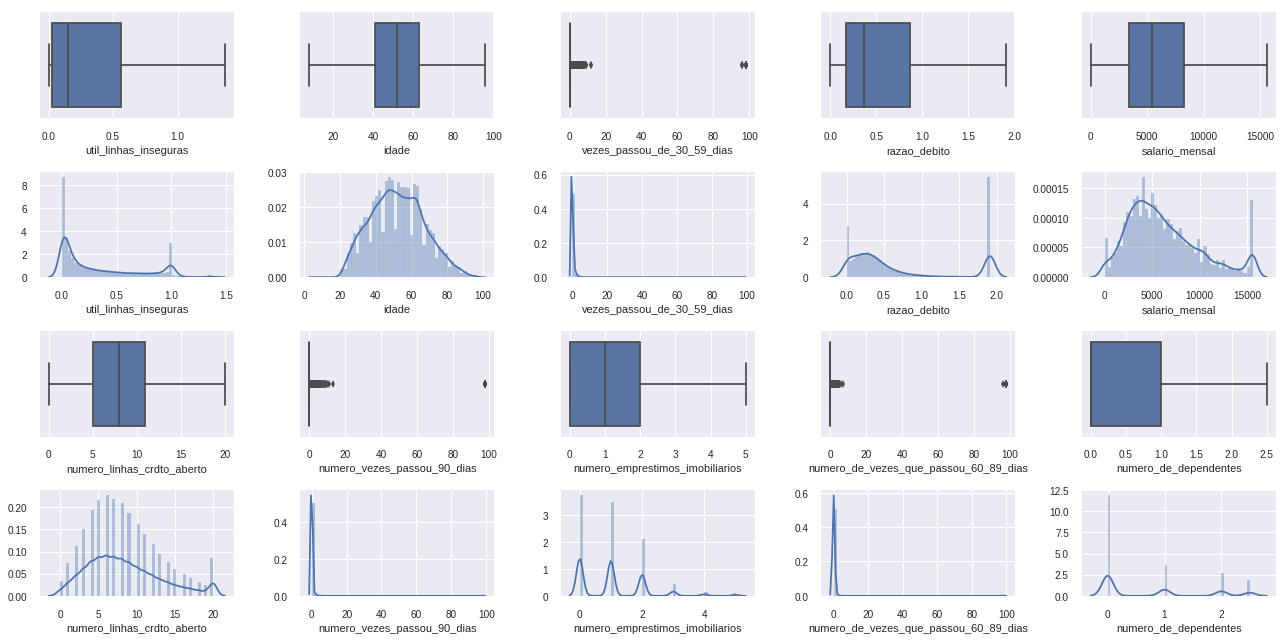

In [9]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(18,9))

sns.boxplot(base_raw['util_linhas_inseguras'], ax=axs[0,0])
sns.boxplot(base_raw['idade'], ax=axs[0,1])
sns.boxplot(base_raw['vezes_passou_de_30_59_dias'], ax=axs[0,2])
sns.boxplot(base_raw['razao_debito'], ax=axs[0,3])
sns.boxplot(base_raw['salario_mensal'], ax=axs[0,4])
sns.boxplot(base_raw['numero_linhas_crdto_aberto'], ax=axs[2,0])
sns.boxplot(base_raw['numero_vezes_passou_90_dias'], ax=axs[2,1])
sns.boxplot(base_raw['numero_emprestimos_imobiliarios'], ax=axs[2,2])
sns.boxplot(base_raw['numero_de_vezes_que_passou_60_89_dias'], ax=axs[2,3])
sns.boxplot(base_raw['numero_de_dependentes'], ax=axs[2,4])


sns.distplot(base_raw['util_linhas_inseguras'], ax=axs[1,0])
sns.distplot(base_raw['idade'], ax=axs[1,1])
sns.distplot(base_raw['vezes_passou_de_30_59_dias'], ax=axs[1,2])
sns.distplot(base_raw['razao_debito'], ax=axs[1,3])
sns.distplot(base_raw['salario_mensal'], ax=axs[1,4])
sns.distplot(base_raw['numero_linhas_crdto_aberto'], ax=axs[3,0])
sns.distplot(base_raw['numero_vezes_passou_90_dias'], ax=axs[3,1])
sns.distplot(base_raw['numero_emprestimos_imobiliarios'], ax=axs[3,2])
sns.distplot(base_raw['numero_de_vezes_que_passou_60_89_dias'], ax=axs[3,3])
sns.distplot(base_raw['numero_de_dependentes'], ax=axs[3,4])


fig.tight_layout()

### 1.2 Análise Gráfica e Transformação Scores de Bureau Categóricos em Numéricos, acerca da Inadimplência

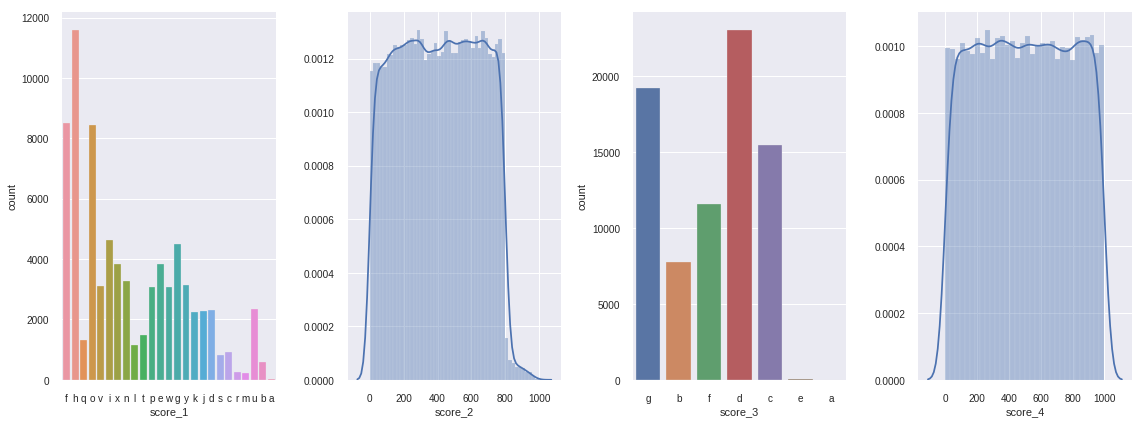

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16,6))

sns.countplot(base_raw['score_1'], ax=axs[0])
sns.distplot(base_raw['score_2'], ax=axs[1])
sns.countplot(base_raw['score_3'], ax=axs[2])
sns.distplot(base_raw['score_4'], ax=axs[3])

fig.tight_layout()

In [11]:
def tratamento_categoricas(BASE,VARIAVEIS_CATEGORICAS):
    categoricas = BASE[VARIAVEIS_CATEGORICAS]
    categoricas[NOME_DA_TARGET] = BASE[NOME_DA_TARGET]
    frames_hierarquia = []
    for i in VARIAVEIS_CATEGORICAS:
        hierarquia = pd.crosstab(categoricas[i], categoricas[NOME_DA_TARGET],  
                                 margins = False).apply(lambda row: row/row.sum(),axis=1).sort_values(by=1, ascending = True)
        INDEX = []
        frames_hierarquia.append(hierarquia)
        for row in hierarquia.index: 
            INDEX.append(row)
        for k in range(0,len(INDEX)):
            categoricas.loc[(categoricas[i]==INDEX[k]), i] = k
            categoricas = categoricas.copy()
    return categoricas,frames_hierarquia

def cria_dicionario(hierarquias):
    for i in range(0,len(hierarquias)):
        INDEX = hierarquias[i].index
        hierarquias[i]['DICIONARIO'] = list(range(0,len(hierarquias[i].index)))
    dicionarios = []
    for k in range(0,len(hierarquias)):
        dicionarios.append([hierarquias[k].index.name,list(zip(hierarquias[k].index, hierarquias[k].DICIONARIO.values))])
    return hierarquias, dicionarios

def load_dicionario(base,dicionario):
    for i in range(0,len(dicionario)):
        for k in range(0,len(dicionario[i][1])):
            base.loc[(base[dicionario[i][0]]==dicionario[i][1][k][0]),(dicionario[i][0])] = dicionario[i][1][k][1]
            base = base.copy() 
    return base

In [12]:
VARIAVEIS_CATEG ,hierarquias = tratamento_categoricas(base_raw,['score_1','score_3'])
hierarquias_enriquecidas,dicionario = cria_dicionario(hierarquias)

In [13]:
base_raw['score_1'] = VARIAVEIS_CATEG['score_1']
base_raw['score_3'] = VARIAVEIS_CATEG['score_3']

### 1.3 Análise do Balanceamento da Variável Resposta

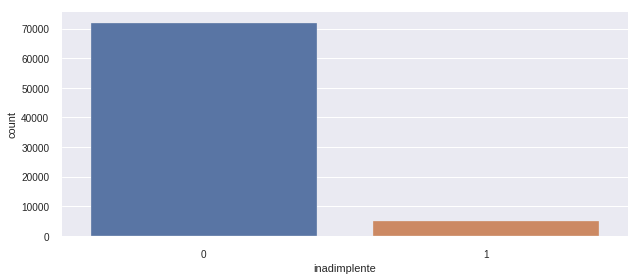

In [14]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(9,4))
sns.countplot(base_raw['inadimplente'].apply(str))
fig.tight_layout()

In [15]:
print('A Disposição da variável resposta na base de dados é:'),
print(round((base_raw['inadimplente'].value_counts()/base_raw.shape[0])*100,2),'em %')

A Disposição da variável resposta na base de dados é:
0    93.36
1     6.64
Name: inadimplente, dtype: float64 em %


## 2. Aplicação do Classificador XGBOOST para Modelagem do Score Interno

### 2.1 Classe de Modelagem do XGBOOST (Obs: Performance Estimada a partir da métrica AUC)

In [16]:
class Modelagem:
    
    def __init__(self):
        
        """
            Verifica se pacotes estão instalados. Se não estiver, sugere instalar.
        """
        
        # XGBoost
        try:
            import xgboost as xgb
        except ImportError as e:
            print('Instalar XGBoost. Execute o seguinte comando: !pip install "xgboost==0.90"')
        
        # Scikit-Learn
        try:
            import sklearn
        except ImportError as e:
            print('Instalar Scikit-Learn. Execute o seguinte comando: !pip install "sklearn==0.20.2"')
            
        # Otimização Bayesiana
        try:
            import optuna
        except ImportError as e:
            print('Instalar Optuna. Execute o seguinte comando: !pip install "optuna==1.0.0"')
        
        # Funções estatísticas
        try:
            import scipy.stats
        except ImportError as e:
            print('Instalar Scipy. Execute o seguinte comando: !pip install "scipy==1.2.0"')
        
        # Pickle -> serialização de modelos
        try:
            import pickle as pkl
        except ImportError as e:
            print('Instalar Pickle. Execute o seguinte comando: !pip install "pickle==4.0"')
            
        print('Conjunto de funções para construção de modelos de machine learning')
 
  
    def validacao_cruzada_xgb(self, X, y, n_splits=5, shuffle=True, n_jobs=2, n_iter=5, random_state=42):
        """
            Treina o XGBoost a partir de uma Validação Cruzada Estratificada ( StratifiedKFold ) com RandomizedSearchCV

            Parâmetros
            ----------
            X            : pandas dataframe. Base que irá treinar o modelo.
            y            : array. Target do modelo.
            n_splits     : inteiro. Número de folds para a validação cruzada.
            shuffle      : booleano. Faz splits aleatórios com reposição.
            n_jobs       : inteiro. Número cores que serão usados para processamento. -1 faz usar todos disponíveis.
            n_iter       : inteiro. Número de vezes que a validação cruzada será executada.
            random_state : inteiro. Semente de aleatoriedade.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        import xgboost as xgb
        from sklearn.metrics import roc_auc_score              # Calcula ROC
        from sklearn.model_selection import StratifiedKFold    # Cria KFold estratificado
        from sklearn.model_selection import RandomizedSearchCV # Busca Aleatória de Parâmetros,
            
        # Cria amostras estratificadas
        cv = StratifiedKFold(
            n_splits     = n_splits,
            shuffle      = shuffle,
            random_state = random_state
        )
        
        # Parâmetros padrão do modelo
        params_fixed = {
            'objective': 'binary:logistic',   # Objetivo do modelo
            'silent'   : 1,                   # Atualiza status do modelo. 0 para não mostrar e 1 para mostrar (bom para debub)
            'seed'     : random_state,        # Semente
            'n_jobs'   : -1                   # Numero de cores do processador. -1 usa todos disponíveis
        }
        
        params_dist_grid = {
            
            # Profundidade máxima da árvore. Valores muito altos podem overfittar.
            'max_depth'        : [1, 2, 3, 4, 5, 6, 7],
            
            # Determina o mínimo de redução de perda necessário para criar um split. Deixa o algoritmo conservador.
            'gamma'            : [0, 0.5, 1],
            
            # Número de estimadores para o modelo. Valores muito altos podem overfittar.
            'n_estimators'     : scipy.stats.randint(1, 1001),
            
            # Taxa de aprendizado. Valores muito pequenos deixam o modelo mais lento para treinar.
            'learning_rate'    : scipy.stats.uniform(),
            
            # Determina a fração de observações a serem consideradas quando constrói cada árvore.
            # Tianqi Chen e Carlos Guestrin, no paper do XGBoost, recomendam o uso desse parâmetro.
            'subsample'        : scipy.stats.uniform(),
            
            # Determina a fração de colunas a serem escolhidas, randomicamente, para cada árvore.
            'colsample_bytree' : scipy.stats.uniform(),
            
            # Regularização L1. Incentiva a esparsidade -> fazer os pesos tenderem a 0.
            # Pode ser útil quando o objetivo é "objective: binary:logistic" desde que eu precise de ajuda
            # na seleção de variáveis.
            'reg_alpha'        : scipy.stats.uniform(),
            
            # Regularização L2. Incentiva pesos pequenos
            # Essa abordagem pode ser mais útil em métodos de árvore ao zerar as variáveis que não fazem sentido.
            'reg_lambda'       : scipy.stats.uniform(),
        }
        
        # Faz a validação cruzada com as amostras estratificadas
        rs_grid = RandomizedSearchCV(
            estimator=xgb.XGBClassifier(**params_fixed),   # Modelo a ser otimizado
            n_jobs=n_jobs,
            verbose=1,
            param_distributions=params_dist_grid,          # Parâmetros a serem otimizados
            n_iter=n_iter,
            cv=cv,                                         # Objeto de validação cruzada
            scoring='roc_auc',                             # Métrica
            random_state=random_state,
        )
        
        rs_grid.fit(X, y)                                   # Otimiza modelo
        
        print('=' * 80)
        print('Melhores parâmetros:', rs_grid.best_params_)  # Printa os melhores parâmetros
        print('Melhor ROC:', rs_grid.best_score_)            # Printa o melhor ROC

        return rs_grid.best_estimator_                       # Retorna o melhor modelo      
    
    def calcula_ks(self, df, var_score, target, retorna_valor=False):
        """
            Calcula o KS do Score

            Parâmetros
            ----------
            df            : pandas dataframe. Dataframe da base escorada.
            var_score     : string. Nome da variável de score.
            target        : string. Nome da variável target.
            retorna_valor : booleano. Define se retorna valor do KS.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        
        df_ks, valor_ks = TuringEvaluateModels(df, var_score, target)
        print('KS:', valor_ks)
        if retorna_valor:
            display(df_ks)
            return valor_ks
        else:
            return df_ks
    
    def score_validacao_cruzada(self, estimador, X, y, cv=5, n_jobs=-1, scoring='roc_auc', retorna=False):
        """
            Calcula o score na validação cruzada

            Parâmetros
            ----------
            estimador  : modelo. Modelo que irá escorar a base
            X          : pandas dataframe. Conjunto de treino do modelo
            y          : array. Array com as targets para cada individuo
            cv         : inteiro. Número de folds para validação. 
            n_jobs     : inteiro. Número de cores a serem usados para processamento. -1 faz usar todos disponíveis
            scoring    : string. Métrica de desempenho.
            retorna    : booleano. Define se retorna score.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        
        inicio = time.time()
        
        # Calcula scores de validação cruzada
        roc_scores = cross_val_score(
            estimator = estimador, 
            X         = X, 
            y         = y, 
            cv        = cv, 
            n_jobs    = n_jobs, 
            scoring   = scoring
        )

        roc_mean = roc_scores.mean()
        roc_std  = roc_scores.std()
        fim      = time.time() - inicio
        
        print("Média da " + scoring + " na Validação Cruzada: ", round(roc_mean, 3))
        print("Desvio Padrão da " + scoring + " na Validação Cruzada: ", round(roc_std, 3))
        print("Tempo de processamento: ", round(fim, 3), 'segundos')
        
        if retorna:
            return {'media': roc_mean, 'desvio': roc_std}

### 2.2 Demais Funções Complementares

In [17]:
### Função que mostra dataframe lado a lado
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
def metricas(scores,target):
    return pd.DataFrame({
        'KS'   : [ks2(scores,target)],
        'ROC'  : [roc_auc_score(y_score=scores,y_true=target)],
        'GINI' : [2 * roc_auc_score(y_score=scores,y_true=target) - 1]
    })
def ks2(score, alvo):
    b2 = pd.crosstab(score, alvo, rownames = ['score']).reset_index()
    if len(np.unique(alvo)) > 1:
        freq_bom = b2.iloc[:,1]/sum(b2.iloc[:,1])
        freq_mau = b2.iloc[:,2]/sum(b2.iloc[:,2])
        ac_bom = np.cumsum(freq_bom)
        ac_mau = np.cumsum(freq_mau)
        diff = np.abs(ac_bom - ac_mau).round(7)
        ks = diff.max() * 100
    else:
        ks = 0
    return ks

### 2.3 Aplicação o XGBOOST para Score Interno

In [18]:
modelagem =  Modelagem() 
xgb_model = modelagem.validacao_cruzada_xgb(base_raw.drop(['score_1','score_2','score_3','score_4',NOME_DA_TARGET],axis=1), base_raw[NOME_DA_TARGET], n_jobs = -1,n_splits=5,n_iter=5)

Instalar Optuna. Execute o seguinte comando: !pip install "optuna==1.0.0"
Conjunto de funções para construção de modelos de machine learning
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:    4.2s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.6s finished


Melhores parâmetros: {'colsample_bytree': 0.8661761457749352, 'gamma': 1, 'learning_rate': 0.020584494295802447, 'max_depth': 2, 'n_estimators': 344, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.21233911067827616, 'subsample': 0.18182496720710062}
Melhor ROC: 0.8264348784961084


### 2.4 Análise de Performance Global Esperada

In [19]:
probabilidades_predicoes= xgb_model.predict_proba(base_raw.drop(['score_1','score_2','score_3','score_4',NOME_DA_TARGET],axis=1)) 
base_raw['score_interno']= (probabilidades_predicoes[:,1])

display_side_by_side(*[metricas(base_raw['score_interno'], base_raw[NOME_DA_TARGET])])

,GINI,KS,ROC
0,0.657433,51.18724,0.828716


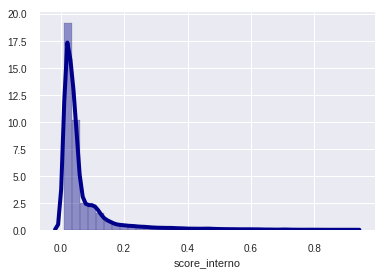

In [20]:
sns.distplot(base_raw['score_interno'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## 3. Combinação do Score Interno com os Scores de Bureau por Classificador Logístico 

In [21]:
X = base_raw[['score_interno','score_1','score_2','score_3','score_4']]
X = X.fillna(-999) # Elucubrando a Possibilidade de um dos Bureau não trazer a informação de um cliente (Nan; Missing)
y= base_raw[NOME_DA_TARGET]
numero_repeticoes = 10
logreg = LogisticRegression()
resultados = []
for k in range(0,numero_repeticoes):
        metricas_cada_validacao = []
        i = 0
        skf = StratifiedKFold(n_splits=2+k, random_state=None)
        for train_index, val_index in skf.split(X,y): 
            i = 1 + i
            X_train, X_test = X.loc[train_index], X.loc[val_index] 
            y_train, y_test = y.loc[train_index], y.loc[val_index]
            logreg.fit(X_train,y_train)
            metricas_cada_validacao.append(metricas(logreg.predict_proba(X_test)[:,1],y_test))
            print("Resultado da Validação nº",i,":",metricas(logreg.predict_proba(X_test)[:,0],y_test))
        resultados.append(pd.DataFrame({'Validacao '+str(k):pd.concat(metricas_cada_validacao).apply(np.mean,axis=0)}))

Resultado da Validação nº 1 :        GINI        KS       ROC
0 -0.694193  53.28868  0.152903
Resultado da Validação nº 2 :        GINI        KS       ROC
0 -0.684935  52.60604  0.157532
Resultado da Validação nº 1 :       GINI        KS      ROC
0 -0.69292  53.10961  0.15354
Resultado da Validação nº 2 :        GINI        KS       ROC
0 -0.682433  52.58155  0.158783
Resultado da Validação nº 3 :      GINI        KS     ROC
0 -0.6936  53.37727  0.1532
Resultado da Validação nº 1 :        GINI        KS       ROC
0 -0.689085  53.10058  0.155457
Resultado da Validação nº 2 :        GINI       KS      ROC
0 -0.700979  53.7171  0.14951
Resultado da Validação nº 3 :        GINI        KS       ROC
0 -0.646035  47.33707  0.176983
Resultado da Validação nº 4 :        GINI        KS       ROC
0 -0.694738  52.90544  0.152631
Resultado da Validação nº 1 :        GINI        KS       ROC
0 -0.700588  54.61591  0.149706
Resultado da Validação nº 2 :        GINI        KS       ROC
0 -0.680927  5

In [22]:
pd.concat(resultados,axis=1)

,Validacao 0,Validacao 1,Validacao 2,Validacao 3,Validacao 4,Validacao 5,Validacao 6,Validacao 7,Validacao 8,Validacao 9
GINI,0.689564,0.689651,0.682709,0.678026,0.690025,0.688831,0.661743,0.685505,0.684002,0.680133
KS,52.947360,53.022810,51.765047,52.132764,53.376157,53.447553,50.779366,52.938101,53.183576,52.810750
ROC,0.844782,0.844826,0.841355,0.839013,0.845013,0.844415,0.830871,0.842752,0.842001,0.840067


In [23]:
pd.DataFrame({'Performance Final Esperada':pd.concat(resultados,axis=1).apply(np.mean,axis=1)})

,Performance Final Esperada
GINI,0.683019
KS,52.640348
ROC,0.841510


## 4. Predição das Probabilidades de Inadimplência na Base de Teste

### 4.1 Importação da Base de Teste

In [24]:
ARQUIVO = 'case_test[1].csv'
CAMINHO_SAIDA = CAMINHO
ARQUIVO_SAIDA = 'case_test[2].csv'
base_test = boto3.client('s3').get_object(Bucket=NM_BUCKET, Key=CAMINHO + ARQUIVO)
base_test = pd.read_csv(base_test['Body'], sep=',', encoding='latin-1') # Rodando base Full
print('A Base importada tem', base_test.shape[0], 'linhas e', base_test.shape[1], 'colunas.')
base_test_backup = base_test.copy()

A Base importada tem 33000 linhas e 14 colunas.


### 4.2 Aplicação de Tratamento de Outliers (mediante medidas salvas da base de Treinamento)

In [25]:
cols_numericas = ['util_linhas_inseguras','idade',
                  'razao_debito','salario_mensal','numero_linhas_crdto_aberto',
                  'numero_emprestimos_imobiliarios','numero_de_dependentes']

In [26]:
base_test.loc[:, cols_numericas] = trata_outlier.transform(base_test[cols_numericas])

### 4.3 Numeralizar variáveis categóricas (mediante dicionário criado na base de Treinamento)

In [27]:
variaveis_categoricas = ['score_1','score_3']
var_nume = load_dicionario(base_test[variaveis_categoricas],dicionario)

In [28]:
base_test['score_1'] = var_nume['score_1']
base_test['score_3'] = var_nume['score_3']

### 4.4 Aplicação do XGBOOST para criação do Score Interno

In [29]:
probabilidades_predicoes= xgb_model.predict_proba(base_test.drop(['score_1','score_2','score_3','score_4'],axis=1)) 
base_test['score_interno']= (probabilidades_predicoes[:,1])

### 4.5 Aplicação da Logística para criação das variáveis de probabilidade de inadimplência e flag inadimplência

In [30]:
X = base_test[['score_interno','score_1','score_2','score_3','score_4']]
X = X.fillna(-999) # Elucubrando a Possibilidade de um dos Bureau não trazer a informação de um cliente (Nan; Missing)
base_test['probabilidade_inadimplente'] = logreg.predict_proba(X)[:,1]
base_test['inadimplente'] = logreg.predict(X)

### 4.6 Análise das Variáveis de Previsão

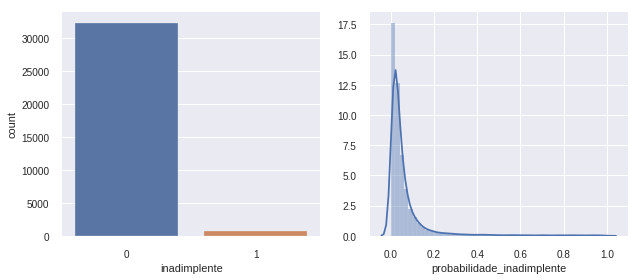

In [32]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
sns.countplot(base_test['inadimplente'].apply(str), ax=axs[0])
sns.distplot(base_test['probabilidade_inadimplente'], ax=axs[1])
fig.tight_layout()

In [34]:
print('A Disposição da variável resposta na base de dados é:'),
print(round((base_test['inadimplente'].value_counts()/base_test.shape[0])*100,2),'em %')

A Disposição da variável resposta na base de dados é:
0    97.93
1     2.07
Name: inadimplente, dtype: float64 em %


## 5. Exportação da Base de Teste para S3 

In [44]:
import s3fs
bytes_to_write = base_test.to_csv(None, index=False, sep=';').encode()
fs = s3fs.S3FileSystem()
with fs.open('s3://'+NM_BUCKET+'/'+CAMINHO_SAIDA+ARQUIVO_SAIDA, 'wb') as f:
    f.write(bytes_to_write)